# Generate word vectors 生成词向量

In [1]:
import re
import string

import numpy as np
import pandas as pd

import jieba
import jieba.analyse

from collections import Counter

from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

## Word segmentation 分词

In [2]:
rev_raw = pd.read_excel('主营构成.xlsx')
rev_raw.dropna(axis=0,thresh=2,inplace=True)
rev_raw.set_index(['证券代码','证券简称'],inplace=True)
rev_raw.columns = [1,2,3,4,5]
rev_raw.fillna('',inplace=True)
rev_raw['business'] = [''.join(i) for i in rev_raw.values]
rev = rev_raw.drop([1,2,3,4,5],axis=1)

In [3]:
rev

,,business
证券代码,证券简称,
000001.SZ,平安银行,利息收入:发放贷款及垫款:个人贷款业务利息收入:发放贷款及垫款:公司贷款业务非利息收入:手续...
000002.SZ,万科A,房地产开发与经营业房地产管理业及其他其他业务
000004.SZ,国华网安,安全加固检测类安全系统平台类集成产品及定制开发类其他业务创世神曲
000005.SZ,ST星源,环保业务收入酒店经营、物业管理收入其他业务
000006.SZ,深振业A,房产销售业务租赁业务代建服务
...,...,...
688799.SH,华纳药厂,其他消化系统类吸入用乙酰半胱氨酸溶液琥珀酸亚铁片双氯芬酸钠缓释片胶体果胶铋干混悬剂
688800.SH,瑞可达,通信连接器产品-通信连接器新能源汽车领域产品-新能源连接器新能源汽车领域产品-新能源连接器模...
688819.SH,天能股份,铅酸电池其他业务锂电池等其他电池


In [4]:
# remove redundant strings
rev['business'] = rev['business'].apply(lambda x: re.sub('其他[主营]*业务','',x))
rev['business'] = rev['business'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation+'、')))

In [5]:
# Jieba: Chinese word segmentation
jieba.enable_paddle()
rev['words'] = rev['business'].apply(lambda x: jieba.lcut(x, use_paddle=True)) # paddle mode

Paddle enabled successfully......


In [6]:
rev

,,business,words
证券代码,证券简称,,
000001.SZ,平安银行,利息收入发放贷款及垫款个人贷款业务利息收入发放贷款及垫款公司贷款业务非利息收入手续费及佣金收...,"[利息, 收入, 发放, 贷款, 及, 垫款, 个人, 贷款, 业务, 利息, 收入, 发放..."
000002.SZ,万科A,房地产开发与经营业房地产管理业及其他,"[房地产, 开发, 与, 经营业房地产管理业, 及, 其他]"
000004.SZ,国华网安,安全加固检测类安全系统平台类集成产品及定制开发类创世神曲,"[安全, 加固, 检测, 类, 安全, 系统, 平台类, 集成, 产品, 及, 定制, 开发..."
000005.SZ,ST星源,环保业务收入酒店经营物业管理收入,"[环保, 业务, 收入, 酒店, 经营, 物业管理, 收入]"
000006.SZ,深振业A,房产销售业务租赁业务代建服务,"[房产, 销售, 业务, 租赁, 业务, 代建, 服务]"
...,...,...,...
688799.SH,华纳药厂,其他消化系统类吸入用乙酰半胱氨酸溶液琥珀酸亚铁片双氯芬酸钠缓释片胶体果胶铋干混悬剂,"[其他, 消化系统类, 吸入, 用, 乙酰, 半胱氨酸溶液, 琥珀酸亚铁片双氯芬酸钠, 缓释..."
688800.SH,瑞可达,通信连接器产品通信连接器新能源汽车领域产品新能源连接器新能源汽车领域产品新能源连接器模块新能...,"[通信连接器, 产品, 通信, 连接器, 新能源汽车, 领域, 产品, 新能源, 连接器, ..."
688819.SH,天能股份,铅酸电池锂电池等其他电池,"[铅酸电池锂电池, 等, 其他, 电池]"


## Word frequency & Cosine similarity 词频统计与余弦相似度

In [7]:
# create a dictionary based on revenue description of all the listed companies
vocabdf_single = rev['words'].apply(lambda x: Counter(x))
vocab = vocabdf_single.values.sum()

In [8]:
vocabdf = pd.DataFrame.from_dict(vocab,orient='index',columns=['freq_total'])
vocabdf['col_index'] = np.arange(vocabdf.shape[0])
vocabdf

,freq_total,col_index
利息,207,0
收入,833,1
发放,90,2
贷款,164,3
及,1430,4
...,...,...
通信连接器,1,6764
铅酸电池锂电池,1,6765
代工,1,6766
智能电动平衡车,1,6767


In [9]:
# construct frequency vector
n = len(rev)
v = len(vocab)

fre = np.zeros(shape=(n,v))
for i in range(n):
    for word in rev.iloc[i,1]:
        j = vocabdf.loc[word,'col_index']
        freq_word = vocabdf_single[i][word]
        fre[i,j] = freq_word

In [10]:
# calculate cosine similarity
sim_matrix = np.zeros(shape=(n,n))
for i in range(n):
    for j in range(n):
        sim_matrix[i][j] = np.dot(fre[i],fre[j]) / np.sqrt(np.dot(fre[i],fre[i])*np.dot(fre[j],fre[j]))

G:\anaconda3\envs\jieba\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [11]:
sim_matrix

array([[1.        , 0.12830006, 0.07209841, ..., 0.        , 0.        ,
        0.0564445 ],
       [0.12830006, 1.        , 0.18731716, ..., 0.20412415, 0.        ,
        0.14664712],
       [0.07209841, 0.18731716, 1.        , ..., 0.        , 0.        ,
        0.08240856],
       ...,
       [0.        , 0.20412415, 0.        , ..., 1.        , 0.        ,
        0.08980265],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.0564445 , 0.14664712, 0.08240856, ..., 0.08980265, 0.        ,
        1.        ]])

In [12]:
rc = rev.reset_index()['证券简称'].values
simdf = pd.DataFrame(sim_matrix, index=rc, columns=rc)

In [17]:
# samplerc = simdf.sample(n=20,random_state=1234,axis=0).index.values
# sampledf = simdf.loc[samplerc,samplerc]
sampledf = simdf.iloc[list(range(20)),list(range(20))]
sampledf

,平安银行,万科A,国华网安,ST星源,深振业A,*ST全新,神州高铁,中国宝安,美丽生态,深物业A,南玻A,沙河股份,深康佳A,深中华A,深粮控股,深华发A,深科技,深天地A,特力A,飞亚达
平安银行,1.000000,0.128300,0.072098,0.523783,0.209513,0.0,0.000000,0.000000,0.000000,0.000000,0.152443,0.000000,0.198762,0.111111,0.233434,0.444444,0.118783,0.128300,0.090722,0.162288
万科A,0.128300,1.000000,0.187317,0.000000,0.000000,0.0,0.073324,0.288675,0.204124,0.365148,0.198030,0.288675,0.129099,0.288675,0.379049,0.000000,0.000000,0.500000,0.117851,0.000000
国华网安,0.072098,0.187317,1.000000,0.000000,0.000000,0.0,0.041204,0.000000,0.000000,0.102598,0.166924,0.000000,0.000000,0.081111,0.170406,0.000000,0.086711,0.093659,0.132453,0.000000
ST星源,0.523783,0.000000,0.000000,1.000000,0.222222,0.0,0.000000,0.000000,0.000000,0.149071,0.000000,0.235702,0.316228,0.000000,0.000000,0.471405,0.125988,0.000000,0.000000,0.172133
深振业A,0.209513,0.000000,0.000000,0.222222,1.000000,0.0,0.000000,0.000000,0.000000,0.149071,0.000000,0.000000,0.421637,0.000000,0.123797,0.000000,0.251976,0.136083,0.096225,0.516398
*ST全新,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
神州高铁,0.000000,0.073324,0.041204,0.000000,0.000000,0.0,1.000000,0.063500,0.089803,0.160644,0.000000,0.000000,0.056796,0.063500,0.033352,0.000000,0.000000,0.073324,0.103695,0.000000
中国宝安,0.000000,0.288675,0.000000,0.000000,0.000000,0.0,0.063500,1.000000,0.176777,0.158114,0.000000,0.250000,0.111803,0.125000,0.065653,0.000000,0.000000,0.288675,0.000000,0.000000
美丽生态,0.000000,0.204124,0.000000,0.000000,0.000000,0.0,0.089803,0.176777,1.000000,0.000000,0.121268,0.000000,0.158114,0.176777,0.092848,0.000000,0.000000,0.204124,0.000000,0.000000
深物业A,0.000000,0.365148,0.102598,0.149071,0.149071,0.0,0.160644,0.158114,0.000000,1.000000,0.000000,0.632456,0.000000,0.000000,0.083045,0.000000,0.000000,0.365148,0.258199,0.115470


In [22]:
wordsdf = rev.reset_index()
wordsdf.set_index('证券简称',inplace=True)

In [23]:
with pd.ExcelWriter('similarity_matrix_sample.xlsx') as writer:
    sampledf.to_excel(writer, sheet_name='sim_matrix')
    wordsdf.loc[sampledf.index,'words'].to_excel(writer ,sheet_name='business_details')

## Word2Vec

In [7]:
myw2v = Word2Vec(rev.words, vector_size=250, sg=1) # Word2Vec

In [8]:
# generate an aggregated vector which implies its business field for each listed company
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [9]:
vectorized_docs = vectorize(rev.words, model=myw2v)
len(vectorized_docs), len(vectorized_docs[0])

(4494, 250)

# Industry classification 行业分类

## First-class industries 一级行业分类
 * refering to Shenwan Industry Classification(2021): 31 first-class industries in total 参考申万行业分类(2021)：共31个一级行业
 * Therefore, the range of k is set in (20,40) when finding the optimal number of clusters.

***Note: Shenwan Industry Classification is a widely accepted industry classification system in China's A-share market.***

In [10]:
# Finding the optimal number of clusters in range(20,40)
# Standard 1: inertia (elbow rule)
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100).fit(vectorized_docs)\
    for k in range(20,40)]
inertias = [model.inertia_ for model in kmeans_per_k]

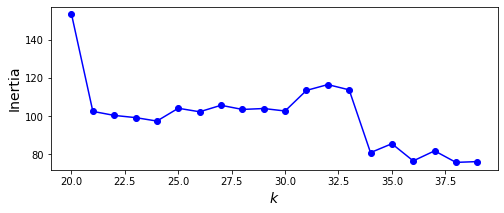

In [11]:
# according to elbow rule, k=34
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
plt.plot(range(20,40), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [12]:
km = MiniBatchKMeans(n_clusters=34, batch_size=100)
rev['industry'] = km.fit_predict(vectorized_docs)
rev.sort_values('industry',ascending=True).to_excel('industries_clustering_1_tier_classification_elbow.xlsx')

In [13]:
# Standard 2: silhouette_scores
silhouette_scores = [silhouette_score(vectorized_docs, model.labels_) for model in kmeans_per_k]

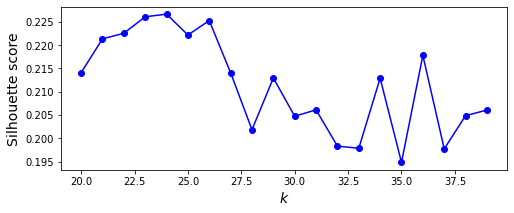

In [14]:
plt.figure(figsize=(8, 3))
plt.plot(range(20,40), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [15]:
np.argmax(np.array(silhouette_scores)) # according silhouette score, k=24

4

In [24]:
km = MiniBatchKMeans(n_clusters=24, batch_size=100)
rev['industry'] = km.fit_predict(vectorized_docs)
rev.sort_values('industry',ascending=True).to_excel('industries_clustering_1_tier_classification_silhouette_score.xlsx')

## Second-class industries 二级行业分类
 * refering to Shenwan Industry Classification(2021): 134 first-class industries in total 参考申万行业分类(2021)：共134个二级行业
 * Therefore, the range of k is set in (120,140) when finding the optimal number of clusters.

***Note: Shenwan Industry Classification is a widely accepted industry classification system in China's A-share market.***

In [17]:
# Finding the optimal number of clusters in range(120,140)
# Standard 1: inertia (elbow rule)
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100).fit(vectorized_docs)\
    for k in range(120,140)]
inertias = [model.inertia_ for model in kmeans_per_k]

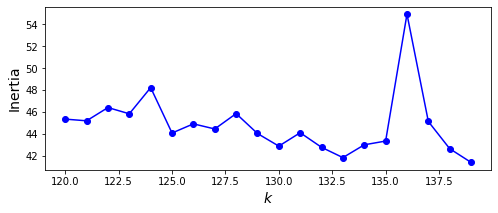

In [18]:
# according to elbow rule, k=130
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
plt.plot(range(120,140), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [19]:
km = MiniBatchKMeans(n_clusters=130, batch_size=100)
rev['industry'] = km.fit_predict(vectorized_docs)
rev.sort_values('industry',ascending=True).to_excel('industries_clustering_2_tier_classification_elbow.xlsx')

In [20]:
# Standard 2: silhouette_scores
silhouette_scores = [silhouette_score(vectorized_docs, model.labels_) for model in kmeans_per_k]

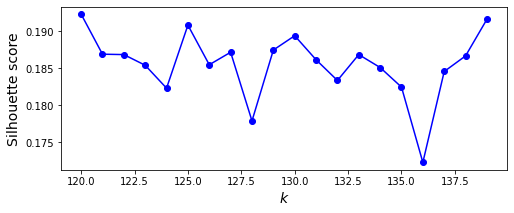

In [21]:
plt.figure(figsize=(8, 3))
plt.plot(range(120,140), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [22]:
np.argmax(np.array(silhouette_scores)) # according silhouette score, k=120

0

In [25]:
km = MiniBatchKMeans(n_clusters=120, batch_size=100)
rev['industry'] = km.fit_predict(vectorized_docs)
rev.sort_values('industry',ascending=True).to_excel('industries_clustering_2_tier_classification_silhouette_score.xlsx')